# Do some statistics on the tags

Let's take a quick look at the Stackoverflow R tags and see if we can get any insights into the R ecosystem.

In [54]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

from scipy.sparse import csr_matrix

import seaborn as sns

%config InlineBackend.figure_format = 'retina'

Answers.csv
Data statistics.ipynb
Questions.csv
Tags.csv



In [55]:
tags = pd.read_csv("./Tags.csv")

In [56]:
tags.head()

,Id,Tag
0,77434,vector
1,79709,memory
2,79709,function
3,79709,global-variables
4,79709,side-effects


In [57]:
tags.shape

(241546, 2)

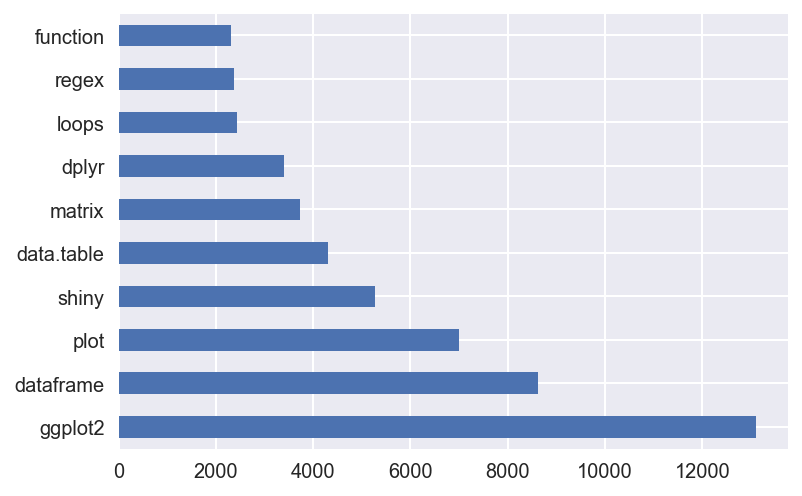

In [58]:
# Let's check out the most popular tags:
tags["Tag"].value_counts().head(10).plot(kind="barh")

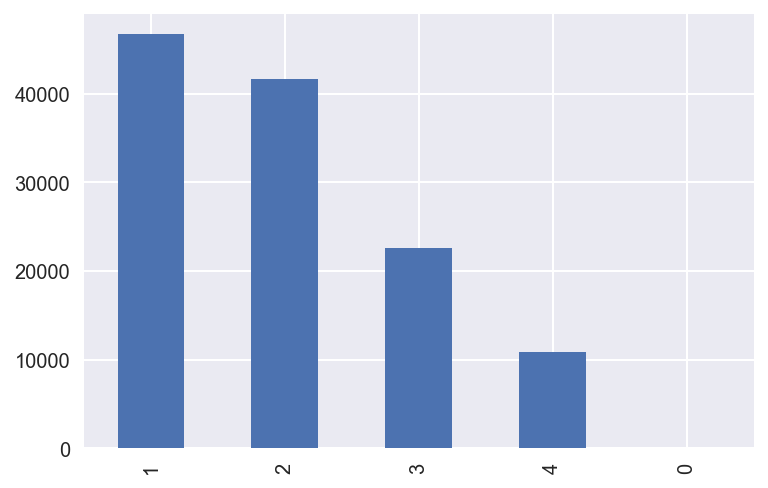

In [59]:
# And the number of tags per question:
(tags.groupby("Id")["Tag"].count().value_counts().plot(kind = "bar"))

The majority of tagged questions have one or two tags with four tags max.

I'm curious about the relationships and connections between different tags so for now we'll limit our scope to only looking at questions with 4 tags and only look at the 1000 most popular tags.

In [60]:
tag_counts = tags.groupby("Id")["Tag"].count()
many_tags = tag_counts[tag_counts > 3].index
popular_tags = tags.Tag.value_counts().iloc[:1000].index

tags = tags[tags["Id"].isin(many_tags)] #getting questions with 4 tags
tags = tags[tags["Tag"].isin(popular_tags)] #getting only top 1000 tags

In [61]:
tags.shape

(37903, 2)

In [62]:
tags.head(20)

,Id,Tag
1,79709,memory
2,79709,function
3,79709,global-variables
10,255697,math
11,255697,statistics
12,255697,bayesian
32,713878,matrix
33,713878,linear-algebra
34,713878,sparse-matrix
63,952275,regex


Creating a Bag of Tags:

Now I am going to create a bag of tags and do some kind of dimensionality reduction on it. To do this I'll basically have to spread the tags and create one column for each tag. Using pd.pivot works but it's very memory-intensive. Instead I'll take advantage of the sparsity and use scipy sparse matrices the create the bag of tags. This sparse bag idea was inspired by dune_dweller's script.

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline

In [70]:
#let's integer encode the id's and tags:
tag_encoder = LabelEncoder()
question_encoder = LabelEncoder()

tags["Tag"] = tag_encoder.fit_transform(tags["Tag"])
tags["Id"] = question_encoder.fit_transform(tags["Id"])

In [71]:
tags.head()

,Id,Tag
1,0,493
2,0,278
3,0,309
10,1,480
11,1,855


In [76]:
tag_num = np.max(tags["Tag"]) + 1

In [80]:
print (tag_num)

998


In [81]:
id_num = np.max(tags["Id"]) + 1

In [82]:
print (id_num)

10900


!@!@!@!|

In [83]:
X = csr_matrix((np.ones(tags.shape[0]), (tags.Id, tags.Tag)))
X.shape #one row for each question, one column for each tag

(10900, 998)

In [84]:
tags.shape

(37903, 2)

Dimensionality Reduction using SVD:

Now we will project our bags of words matrix into a 3 dimensional subspace that captures as much of the variance as possible. Hopefully this will help us better understand the connections between the tags.

In [86]:
model = TruncatedSVD(n_components=3)
model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

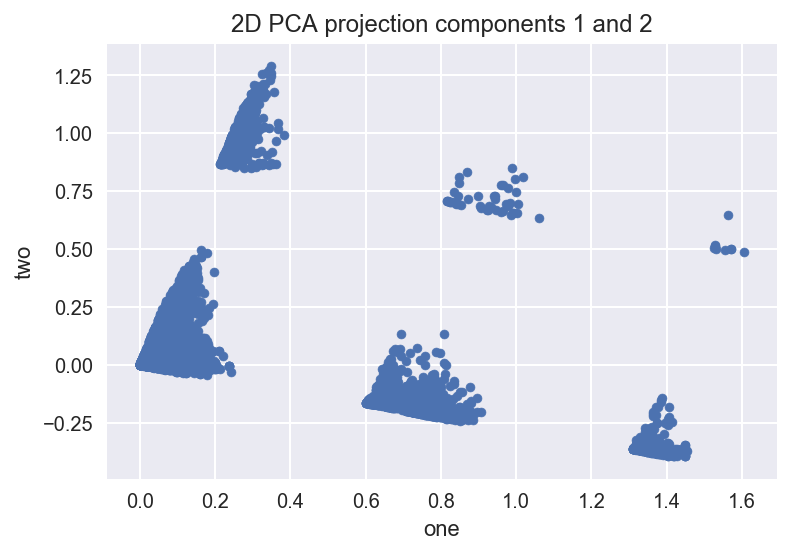

In [87]:
two_components = pd.DataFrame(model.transform(X),\
                              columns=["one", "two", "three"])
two_components.plot(x = "one", y = "two",kind = "scatter",\
                    title = "2D PCA projection components 1 and 2")

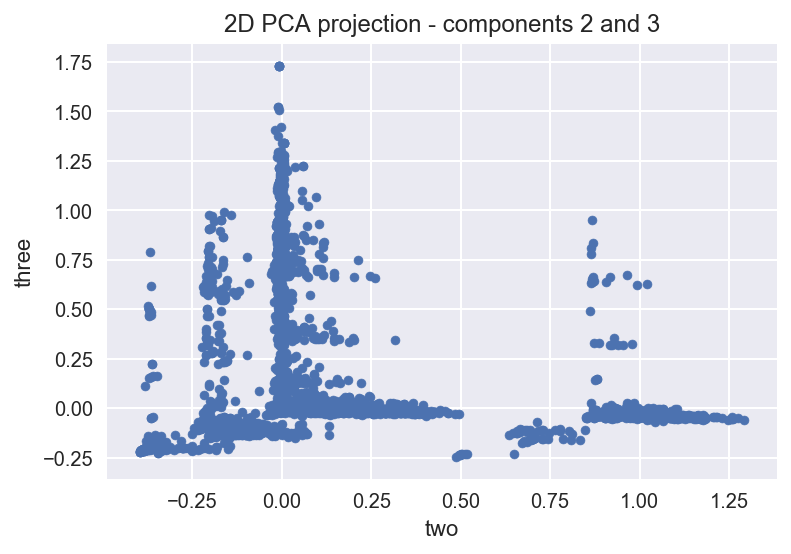

In [89]:
two_components.plot(x = "two", y = "three", kind = "scatter", \
                    title = "2D PCA projection - components 2 and 3")

In [90]:
tagz = popular_tags[:20]

tag_ids = tag_encoder.transform(tagz)
n = len(tag_ids)
print (n)

20


In [91]:
X_new = csr_matrix((np.ones(n), (pd.Series(range(n)), tag_ids)),\
                   shape = (n, 998))

In [92]:
proj = pd.DataFrame(model.transform(X_new)[:,:2], index=tagz, \
                    columns = ["one", "two"])
proj["tag"] = proj.index

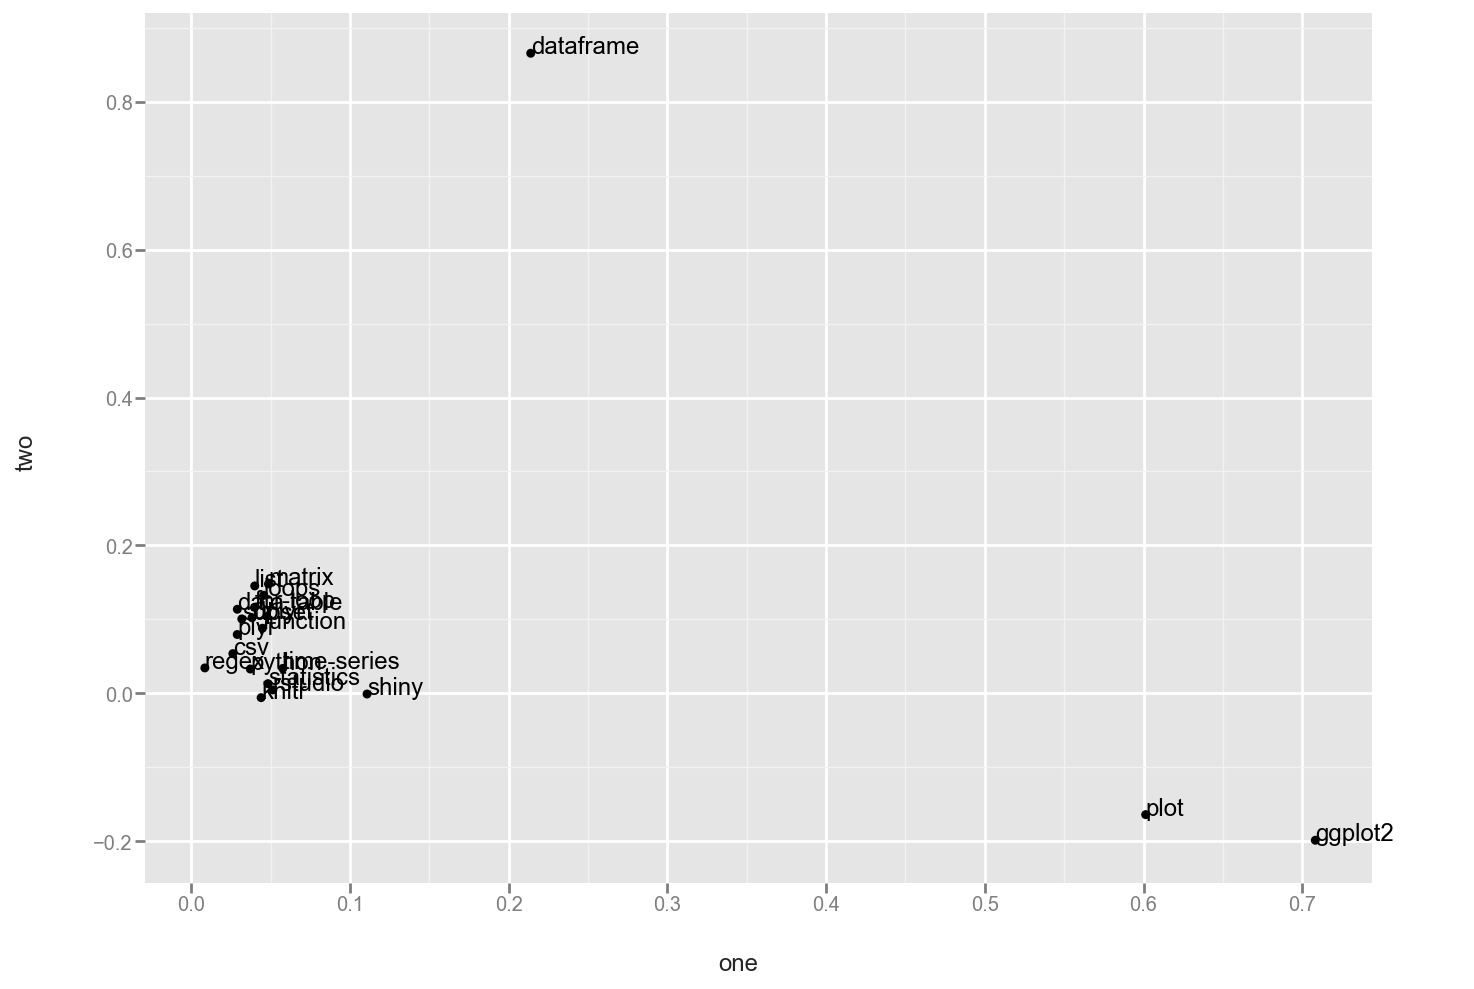

In [94]:
from ggplot import * #ggplot!
plt = (ggplot(proj, aes(x = "one", y = "two", label = "tag")) +
            geom_point() +
            geom_text())
plt.show()

C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


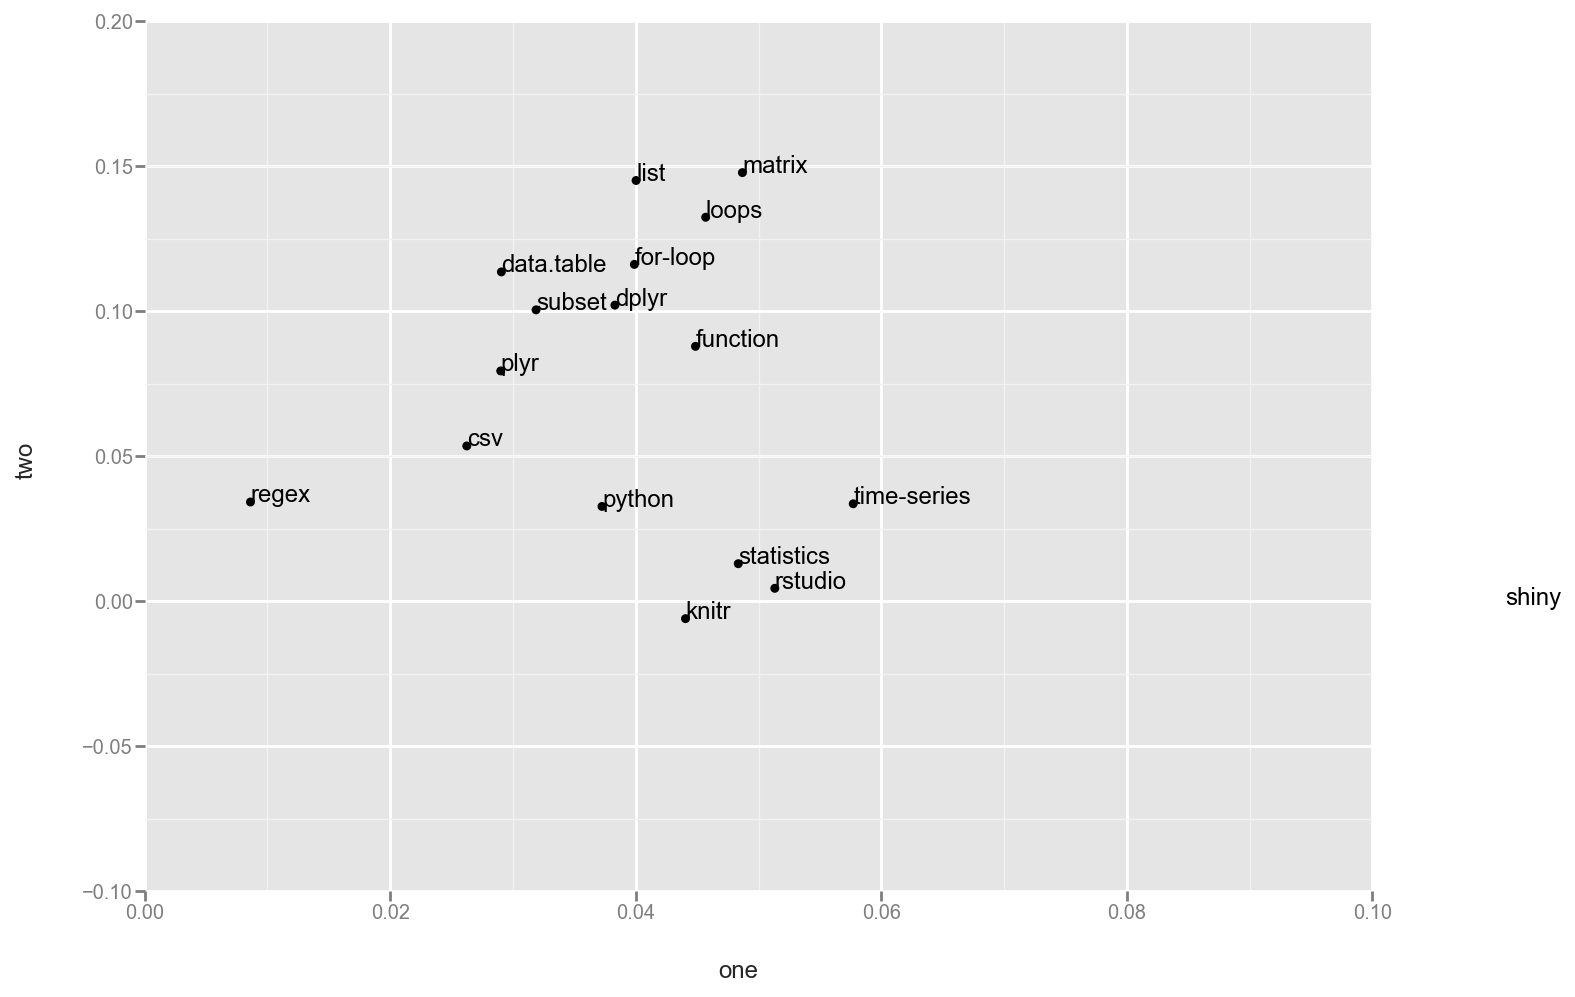

In [95]:
sm_proj = proj[proj["one"] < 0.2][proj["two"] < 0.2]
plt = (ggplot(sm_proj, aes(x = "one", y = "two", label = "tag")) +
            geom_point() +
            geom_text() +
            xlim(0, 0.1) +
            ylim(-0.1, 0.2))
plt.show()